In [1]:
import itertools # product()
import numpy as np
import qutip
import qutip.states
import tomographer
import tomographer.tools.densedm
import tomographer.querrorbars
import tomographer.jpyutil
from IPython.display import display, Markdown

In [2]:
rho_target_Bell = qutip.states.ket2dm(qutip.Qobj(np.array([0,1,1j,0]/np.sqrt(2))))
display(Markdown('rho_target_Bell = '))
display(rho_target_Bell)
# The data below were simulated from the following true state:
rho_sim = 0.95*rho_target_Bell + 0.05*qutip.qeye(4)/4;
display(Markdown('rho_sim = '))
display(rho_sim)

rho_target_Bell = 

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.0+0.j   0.0+0.j   0.0+0.j   0.0+0.j ]
 [ 0.0+0.j   0.5+0.j   0.0-0.5j  0.0+0.j ]
 [ 0.0+0.j   0.0+0.5j  0.5+0.j   0.0+0.j ]
 [ 0.0+0.j   0.0+0.j   0.0+0.j   0.0+0.j ]]

rho_sim = 

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.0125+0.j     0.0000+0.j     0.0000+0.j     0.0000+0.j   ]
 [ 0.0000+0.j     0.4875+0.j     0.0000-0.475j  0.0000+0.j   ]
 [ 0.0000+0.j     0.0000+0.475j  0.4875+0.j     0.0000+0.j   ]
 [ 0.0000+0.j     0.0000+0.j     0.0000+0.j     0.0125+0.j   ]]

In [3]:
# All POVM effects when measuring Pauli X, Y, or Z on a single qubit
MeasEffects1Qubit = tomographer.tools.densedm.PauliMeasEffectsQubit

# Listing of all POVM effects of product Paulis on two qubits (with individual outcomes on each qubit)
Emn = [ None ] * 36 # prepare 36 elements
for i in range(3):
    for j in range(3):
        for s in range(2):
            for t in range(2):
                idx = j*3*2*2 + i*2*2 + t*2 + s
                Emn[idx] = np.kron(MeasEffects1Qubit[i][s], MeasEffects1Qubit[j][t])

# These are the measurement counts. Nm[k] is the number of times the POVM effect
# Emn[k] was observed. The numbers here were obtained by simulating measurements
# from the state `rho_sim` given above using the described measurement settings.
Nm = np.array([
   122,   105,   135,   138, # counts for XX for outcomes (+1, +1), (+1, -1), (-1, +1), (-1, -1)
   248,     7,     5,   240, # counts for XY for outcomes (+1, +1), (+1, -1), (-1, +1), (-1, -1)
   102,   131,   119,   148, # counts for XZ for outcomes (+1, +1), (+1, -1), (-1, +1), (-1, -1)
     7,   252,   240,     1, # counts for YX for outcomes (+1, +1), (+1, -1), (-1, +1), (-1, -1)
   125,   135,   127,   113, # counts for YY for outcomes (+1, +1), (+1, -1), (-1, +1), (-1, -1)
   140,   124,   118,   118, # counts for YZ for outcomes (+1, +1), (+1, -1), (-1, +1), (-1, -1)
   122,   119,   135,   124, # counts for ZX for outcomes (+1, +1), (+1, -1), (-1, +1), (-1, -1)
   126,   123,   134,   117, # counts for ZY for outcomes (+1, +1), (+1, -1), (-1, +1), (-1, -1)
     9,   233,   253,     5, # counts for ZZ for outcomes (+1, +1), (+1, -1), (-1, +1), (-1, -1)
]);

In [4]:
# An entanglement witness which is appropriate for our target state, as a qutip.Qobj
EntglWitness = (- qutip.qeye(4)
    # how do you "collapse systems together" with qutip?? we could do this with np.kron() also...
    - qutip.Qobj(qutip.tensor(qutip.sigmax(),qutip.sigmay()).data,dims=[[4],[4]])
    + qutip.Qobj(qutip.tensor(qutip.sigmay(),qutip.sigmax()).data,dims=[[4],[4]])
    - qutip.Qobj(qutip.tensor(qutip.sigmaz(),qutip.sigmaz()).data,dims=[[4],[4]]) )
display(EntglWitness)

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[-2.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.-2.j  0.+0.j]
 [ 0.+0.j  0.+2.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -2.+0.j]]

In [5]:
# Value for rho_target_Bell maximally entangled state: +2
display(qutip.expect(EntglWitness, rho_target_Bell))

1.9999999999999996

In [6]:
# but you can show that for any separable state this value is <= 0. For example:
display(qutip.expect(EntglWitness, qutip.qeye(4)/4))
display(qutip.expect(EntglWitness, qutip.Qobj(np.array([1,0,0,0]))))
display(qutip.expect(EntglWitness, 0.5*qutip.ket2dm(qutip.Qobj(np.array([0,1,0,0])))
             + 0.5*qutip.ket2dm(qutip.Qobj(np.array([0,0,1,0])))))

-1.0

-2.0

0.0

In [13]:
# Now, we're ready to run our tomography procedure. We'll be estimating
# the expectation value of the entanglement witness.

r = None # global variable

with tomographer.jpyutil.RandWalkProgressBar() as prg:
    r = tomographer.tomorun.tomorun(
        # the dimension of the quantum system
        dim=4,
        # the tomography data
        Nm=Nm,
        Emn=Emn,
        # Histogram: values in [1.6, 2.0] split into 50 bins
        hist_params=tomographer.UniformBinsHistogramParams(1.6,2,50),
        # Random Walk parameters: step size, sweep size, number of thermalization sweeps, number of live sweeps
        mhrw_params=tomographer.MHRWParams(0.009,240,2048,32768),
        # figure of merit:
        fig_of_merit="obs-value",
        observable=EntglWitness.data.toarray(),
        #num_repeats=12, # default value = auto-detect number of CPU's
        progress_fn=prg.progress_fn
    )
    prg.displayFinalInfo(r['final_report_runs'])

In [14]:
# Collect the histogram
final_histogram = r['final_histogram']

Fit parameters:
          a2 = 38.6274
          a1 = 231.251
           m = 41.0814
           c = 115.968
Quantum Error Bars:
          f0 = 1.832
       Delta = 0.03616
       gamma = 0.002461



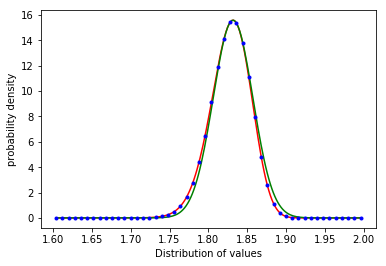

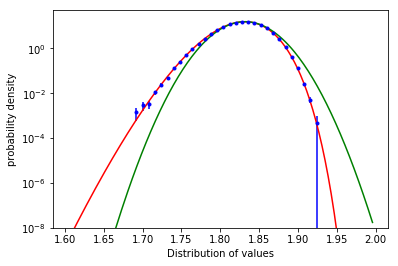

In [15]:
# Do the analysis and get the quantum error bars
analysis = tomographer.querrorbars.HistogramAnalysis(final_histogram, ftox=(2,-1))
analysis.printFitParameters()
analysis.printQuantumErrorBars()
# linear scale plot
analysis.plot()
# log scale plot (adjust scale before showing plot)
p = analysis.plot(log_scale=True, show_plot=False)
p.ax.set_ylim([1e-8, 50])
p.show()